In [1]:
from CO2xSWV import fetch_data_from_NEON_API, make_df
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import multiprocessing
from dataclasses import dataclass
import xarray as xr
import scipy.stats as stats

from dask import delayed
import dask
from dask.diagnostics import ProgressBar

multiprocessing.cpu_count()

40

In [2]:
sitecodes = ['BART', 'ABBY', 'TEAK','GRSM', 'MLBS', 'ORNL', 'DELA', 'LENO', 'TALL', 'DCFS']
#sitecodes = ['BART']

productcodes = ['DP1.00095.001', 'DP1.00094.001','DP1.00041.001']
daterange = ['2015-01', '2020-11']
data_path='/home/jovyan/NEON/CO2xSWV_data'
#fetch_data_from_NEON_API(sitecodes, productcodes, daterange=daterange, data_path=data_path)
# TODO: optimize dask for cyverse

In [8]:
from CO2xSWV import find_HOR_VER
import time

def viable_hours(sites, data_path):
    t0 = time.time()
    lazy = []
    t = t0
    for site in sites:
        try:
            print(f'building delayed objects for {site}...')
            lazy.append(delayed(make_dict_for_site)(site, data_path))
            dt = time.time() - t
            t = time.time()
            print(f'took {dt/60:.3f} minutes')
        except: 
            print(f'{site} failed to make any delayed objects')
    print('Computing results...')
    t = time.time()
    with ProgressBar():
        metadict = list(dask.compute(*lazy))
    dt = time.time() - t 
    print(f'done computing ({dt} seconds).')
    md = dict()
    for entry in metadict:
        md[entry[0]] = entry[1]
    dt = time.time() - t0
    print(f'that took {dt/60:.3f} minutes total')
    return(md)
    

    
def make_dict_for_site(site, data_path):
    '''returns a tuple of site, dict for site'''
    temp_dict = dict()
    temp_dict['horver'] = find_HOR_VER(site, data_path)
    hors = temp_dict['horver'].keys()
    for hor in hors:
        vers = temp_dict['horver'][hor]
        for ver in vers:
            dates = horver_dates(site, hor, ver, data_path)
            temp_dict[hor + ver + '_hours'] = hours_for_horver(hor, ver, dates, site, data_path)
    return((site, temp_dict))

                
def horver_dates(site, hor, ver, data_path):
    '''retuns dates common to all files at given hor, ver'''
    #glob the files
    hv = '.'.join([hor, ver])
    co2 = glob.glob(f'{data_path}/*{site}.DP1.00095.001.{hv}.001.*csv')
    h2o = glob.glob(f'{data_path}/*{site}.DP1.00094.001.{hv}.001.*csv')
    t   = glob.glob(f'{data_path}/*{site}.DP1.00041.001.{hv}.001.*csv')
    # get the dates as sets
    co2d = set([f.split('.')[-4] for f in co2])
    h2od = set([f.split('.')[-4] for f in h2o])
    td   = set([f.split('.')[-4] for f in t])
    # return the intersection as list
    return(list(co2d | h2od | td))
    
def hours_for_horver(hor, ver, dates, site, data_path):
    '''retuns list of all hours with full data for hor, ver, site'''
    dfs = []
    for date in dates:
        dfs.append(make_df(hor, ver, date, site, data_path))
    df = pd.concat(dfs)
    return(list(df.index))



In [9]:
metadict = viable_hours(['BART', 'TALL'], data_path)

building delayed objects for BART...
took 0.000 minutes
building delayed objects for TALL...
took 0.000 minutes
Computing results...
[########################################] | 100% Completed | 28min 53.9s
done computing (1733.9320087432861 seconds).
that took 28.899 minutes total


In [54]:
def print_hours(metadict):
    '''TODO: maybe should find contiguous lengths somehow'''
    
    sites = metadict.keys()
    hours = []
    for site in sites:
        hv = list(metadict[site].keys())
        hv.remove('horver')
        for sensor in hv:
            l = len(metadict[site][sensor])
            hours.append([site, sensor.split('_')[0], l])
    hours.sort(key=lambda x: x[2], reverse=True)
    for hr in hours:
        print(f'{hr[0]} - {hr[1]} has {hr[2]} entries')

print_hours(metadict)

TALL - 001502 has 8176 entries
TALL - 001503 has 8176 entries
TALL - 001501 has 8176 entries
TALL - 002503 has 8176 entries
TALL - 002502 has 8176 entries
TALL - 002501 has 8176 entries
TALL - 003501 has 8176 entries
TALL - 003502 has 8176 entries
TALL - 003503 has 8176 entries
TALL - 004501 has 8176 entries
TALL - 004503 has 8176 entries
TALL - 004502 has 8176 entries
TALL - 005503 has 8176 entries
TALL - 005502 has 8176 entries
TALL - 005501 has 8176 entries
BART - 001501 has 2860 entries
BART - 001502 has 2860 entries
BART - 001503 has 2860 entries
BART - 002503 has 2860 entries
BART - 002502 has 2860 entries
BART - 002501 has 2860 entries
BART - 003501 has 2860 entries
BART - 003502 has 2860 entries
BART - 003503 has 2860 entries
BART - 004503 has 2860 entries
BART - 004502 has 2860 entries
BART - 004501 has 2860 entries
BART - 005503 has 2860 entries
BART - 005502 has 2860 entries
BART - 005501 has 2860 entries


In [50]:
def make_hours_df(metadict):
    lazy = []
    sites = metadict.keys()
    for site in sites:
        hv = list(metadict[site].keys())
        hv.remove('horver')
        for sensor in hv:
            lazy.append(make_sensor_df(site, sensor))
    dfs = list(dask.compute(*lazy))
    df = pd.concat(dfs, axis='columns')
    df.fillna(value=0, inplace=True)
    return(df)
        
@delayed            
def make_sensor_df(site, sensor):        
    full_sensor = site + sensor.split('_')[0]
    df = pd.DataFrame()
    df['hour'] = metadict[site][sensor]
    truth = [1] * len(metadict[site][sensor])
    df[full_sensor] = truth
    df = df.set_index('hour')
    return(df)


In [51]:
df = make_hours_df(metadict)

In [52]:
#df.info()

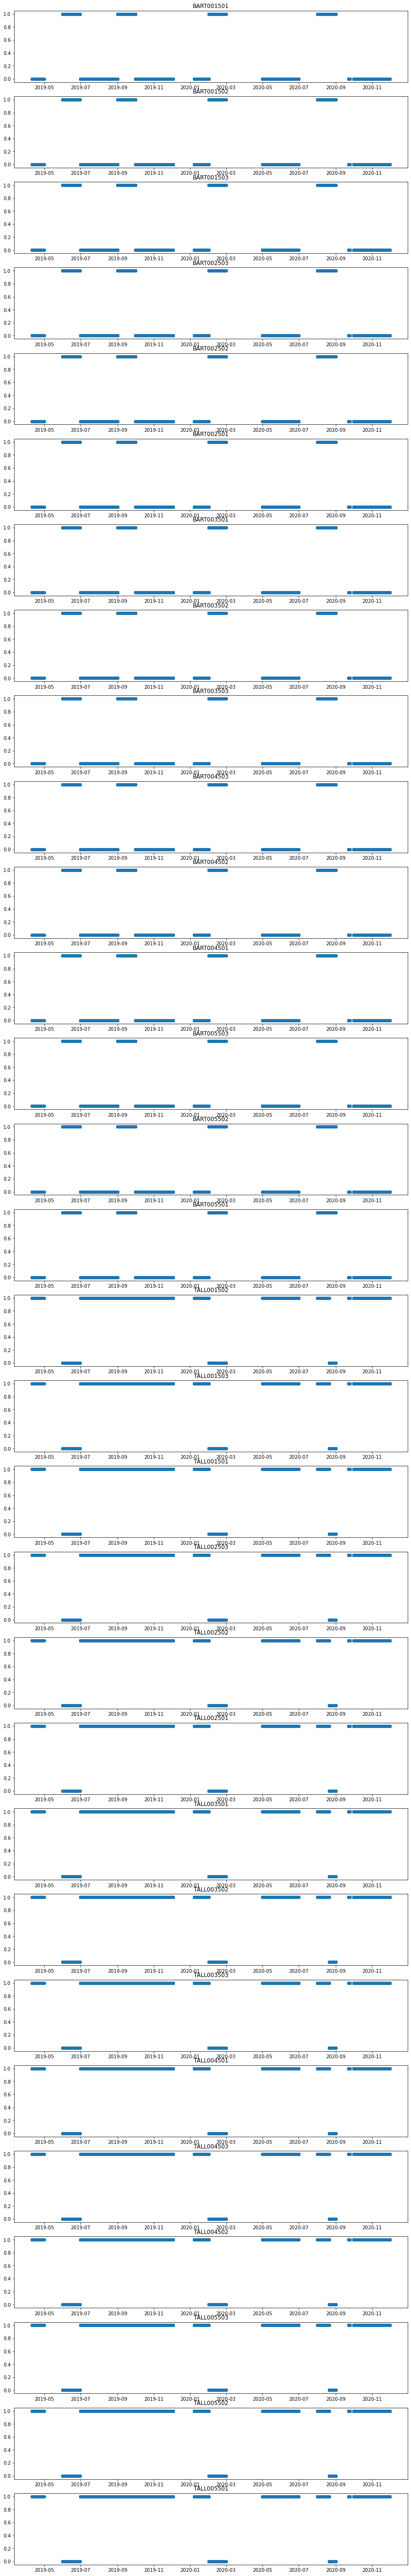

In [53]:

cols = list(df.columns)
fig, axs = plt.subplots(len(cols), figsize=(15, 100))
for i, col in enumerate(cols):
    axs[i].scatter(df.index, df[col]);
    axs[i].title.set_text(col)

In [9]:
def alt_viable_hours(sites, data_path):
    t0 = time.time()
    lazy = []
    combos = []
    print('Making list of hor, ver site combinations....')
    for site in sites:
        horver = find_HOR_VER(site, data_path)
        hors = horver.keys()
        for hor in hors:
            vers = horver[hor]
            for ver in vers:
                dates = horver_dates(site, hor, ver, data_path)
                combo = [hor, ver, dates, site]
                combos.append(combo)
    dt = (time.time() - t0)
    t = time.time()
    print(f'...done ({dt:.3f} seconds)\n ')
                
    print('Building delayed objects...')
    for combo in combos:
        hor, ver, dates, site = combo
        lazy.append(delayed(alt_hours_for_horver)(hor, ver, dates, site, data_path))
    dt = (time.time() - t)
    t = time.time()    
    print(f'...done ({dt:.3f} seconds)\n\nComputing results... ')

    with ProgressBar():
        results = dask.compute(*lazy)
    md = dict()
    for entry in results:
        md[entry[0]] = entry[1]    
    dt = (time.time() - t)
    print(f'...done ({dt:.3f} seconds)\n ')
    dt = (time.time() - t0)
    print(f'Total time of {dt/60:.3f} minutes. ')
    return(md)

def alt_hours_for_horver(hor, ver, dates, site, data_path):
    '''retuns list of all hours with full data for hor, ver, site'''
    dfs = []
    for date in dates:
        dfs.append(make_df(hor, ver, date, site, data_path))
    df = pd.concat(dfs)
    return([f'{site}{hor}{ver}', list(df.index)])


def horver_dates(site, hor, ver, data_path):
    '''retuns dates common to all files at given hor, ver'''
    #glob the files
    hv = '.'.join([hor, ver])
    co2 = glob.glob(f'{data_path}/*{site}.DP1.00095.001.{hv}.001.*csv')
    h2o = glob.glob(f'{data_path}/*{site}.DP1.00094.001.{hv}.001.*csv')
    t   = glob.glob(f'{data_path}/*{site}.DP1.00041.001.{hv}.001.*csv')
    # get the dates as sets
    co2d = set([f.split('.')[-4] for f in co2])
    h2od = set([f.split('.')[-4] for f in h2o])
    td   = set([f.split('.')[-4] for f in t])
    # return the intersection as list
    return(list(co2d | h2od | td))

In [82]:
nn = list(md['ABBY'].keys())
nn

['horver',
 '001503_hours',
 '001502_hours',
 '001501_hours',
 '002502_hours',
 '002501_hours',
 '002503_hours',
 '003503_hours',
 '003501_hours',
 '003502_hours',
 '004502_hours',
 '004503_hours',
 '004501_hours',
 '005501_hours',
 '005503_hours',
 '005502_hours']

In [37]:
# make a hourly df for each hor
# TODO: maybe add progress barr like,
# with ProgressBar():
#     result = list(dask.compute(*lazy))

lazy = []

#for hor, vers in horver.items():
hor = '004'
vers = horver['001'][:2]
for ver in vers:
    lazy = []
    for date in dates:
        lazy.append(delayed(make_df)(hor, ver, date, site, data_path))
    result = list(dask.compute(*lazy))

# concat all the monthly dfs for the HOR.VER into 1
result = [thing for thing in result if len(thing) > 0]
df = pd.concat(result)        


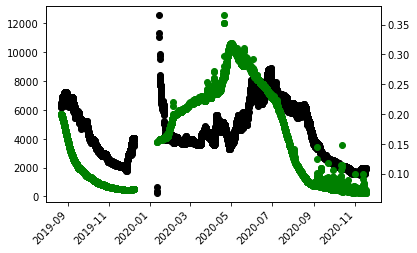

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df.index, df.soilCO2concentrationMean, c='k')
ax2.scatter(df.index, df.VSWCMean, c='g')
fig.autofmt_xdate(rotation=45)

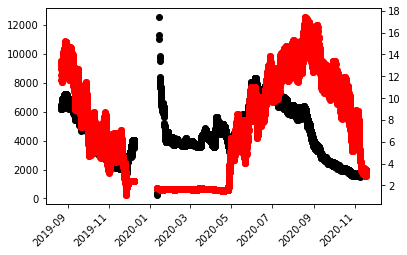

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df.index, df.soilCO2concentrationMean, c='k')
ax2.scatter(df.index, df.soilTempMean, c='r')
fig.autofmt_xdate(rotation=45)

Text(0.5, 0, 'CO2 (ppm?)')

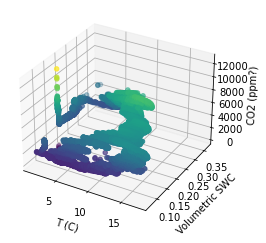

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x = df.soilTempMean
y = df.VSWCMean
z = df.soilCO2concentrationMean

ax.scatter(x, y, z, c=z)

ax.set_xlabel('T (C)')
ax.set_ylabel('Volumetric SWC')
ax.set_zlabel('CO2 (ppm?)')

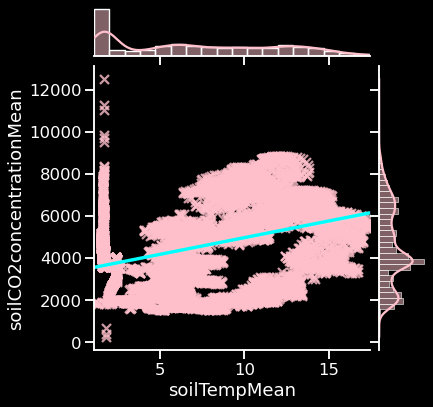

In [8]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='soilTempMean', y='soilCO2concentrationMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})
# aack I wosh seabor would give us r and p!


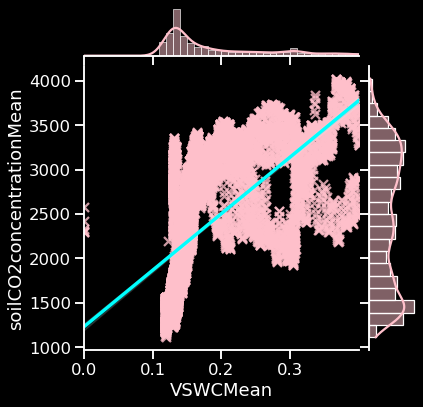

In [9]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='VSWCMean', y='soilCO2concentrationMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})


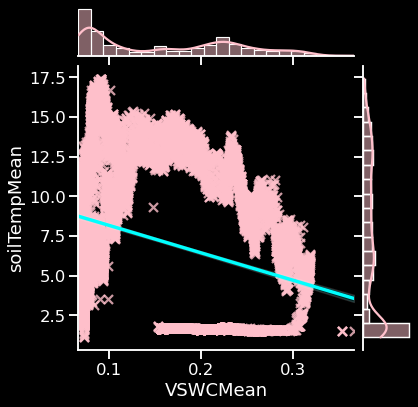

In [9]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='VSWCMean', y='soilTempMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})


### 1) ###
Judging from all of these plots I think there might be a T sensor malfunction insome of the data. Also, double check the sensor positions to make sure the T ansd H2O sensors are lined up. Extract the actual z offset for each from the senor positions to report with each analysis.  Probably ultimately w will want to save a pdf for each sensor with graPHS AND STATISTICAL INFO.

### 2) ###

__a)__ For each dataset in the training sets split to train and validations sets.

__b)__ Create a model. validate.

__c)__ Validate on holdout sites.


In [12]:
import pandas as pd
import requests
import hashlib
import os
import glob

from dask import delayed
import dask
from dask.diagnostics import ProgressBar
from CO2xSWV import dload, make_df

In [14]:

        
        
def viable_hours(sites, products, base_url, dates, data_path):
    for site in sites:
        horver = find_HOR_VER(site, data_path)

